In [3]:
from src.utils import evaluate_model_KL_against_baseline

In [4]:
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
import torch
import torch.optim as optim
from src.zig_model import ZIG

# 1) Load .env
load_dotenv()

# 2) Import your pipeline steps + the allen_api
from src.data_loader import allen_api
from src.pipeline_steps import (
    AnalysisPipeline,
    AllenStimuliFetchStep,
    ImageToEmbeddingStep,
    StimulusGroupKFoldSplitterStep,
    MergeEmbeddingsStep
)
from transformers import ViTModel, ViTImageProcessor

def make_container_dict(boc):
    experiment_container = boc.get_experiment_containers()
    container_ids = [dct['id'] for dct in experiment_container]
    eids = boc.get_ophys_experiments(experiment_container_ids=container_ids)
    df = pd.DataFrame(eids)
    reduced_df = df[['id', 'experiment_container_id', 'session_type']]
    grouped_df = reduced_df.groupby(['experiment_container_id', 'session_type'])[
        'id'].agg(list).reset_index()
    eid_dict = {}
    for row in grouped_df.itertuples(index=False):
        c_id, sess_type, ids = row
        if c_id not in eid_dict:
            eid_dict[c_id] = {}
        eid_dict[c_id][sess_type] = ids[0]
    return eid_dict

def main():
    # A) Allen BOC
    boc = allen_api.get_boc()

    # B) Container dict
    eid_dict = make_container_dict(boc)
    print(len(eid_dict), "containers found.")

    # C) Session->stimuli mapping
    stimulus_session_dict = {
        'three_session_A': ['natural_movie_one', 'natural_movie_three'],
        'three_session_B': ['natural_movie_one', 'natural_scenes'],
        'three_session_C': ['natural_movie_one', 'natural_movie_two'],
        'three_session_C2': ['natural_movie_one', 'natural_movie_two']
    }

    # D) HF model + processor
    processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
    model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    # E) Embedding cache dir
    embedding_cache_dir = os.environ.get('TRANSF_EMBEDDING_PATH', 'embeddings_cache')

    # F) Build pipeline with all steps
    pipeline = AnalysisPipeline([
        AllenStimuliFetchStep(boc),
        ImageToEmbeddingStep(processor, model, embedding_cache_dir),
        StimulusGroupKFoldSplitterStep(boc, eid_dict, stimulus_session_dict, n_splits=10),
        MergeEmbeddingsStep(),  # merges the neural folds with the image embeddings
    ])

    # G) Run pipeline on a single container/session/stimulus
    container_id = 511498742
    #session = 'three_session_A'
    #stimulus = 'natural_movie_three'
    session='three_session_B'
    stimulus='natural_scenes'
    result = pipeline.run((container_id, session, stimulus))

    # H) Print final results
    print("\n=== FINAL PIPELINE OUTPUT ===")
    print("Keys in 'result':", list(result.keys()))
    #  'raw_data_dct', 'embedding_file', 'folds', 'merged_folds', etc.

    print(f"Embedding file path: {result['embedding_file']}")
    folds = result['folds']
    print(f"Number of folds: {len(folds)}")

    merged_folds = result['merged_folds']
    for i, fold_data in enumerate(merged_folds, start=1):
        (Xn_train, Xe_train, Xn_test, Xe_test, frames_train, frames_test) = fold_data
        print(f"\nFold {i}:")
        print(f"  Xn_train: {Xn_train.shape}, Xe_train: {Xe_train.shape}")
        print(f"  Xn_test : {Xn_test.shape},  Xe_test : {Xe_test.shape}")
        print(f"  frames_train: {frames_train.shape}, frames_test: {frames_test.shape}")

    return merged_folds

merged_folds = main()

/home/maria/MouseViT/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


540 containers found.


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BOOM /home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings.pkl
Found existing embeddings for model google_vit-base-patch16-224. Using file:
 /home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings.pkl
      frame  start    end
0        41  16101  16108
1        64  16109  16116
2        91  16116  16123
3        17  16124  16131
4        99  16131  16138
...     ...    ...    ...
5945     23  96067  96074
5946     91  96074  96081
5947     10  96082  96089
5948     78  96089  96096
5949     31  96097  96104

[5950 rows x 3 columns]
(5900, 171)

=== FINAL PIPELINE OUTPUT ===
Keys in 'result': ['container_id', 'session', 'stimulus', 'raw_data_dct', 'embedding_file', 'folds', 'merged_folds']
Embedding file path: /home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings.pkl
Number of folds: 10

Fold 1:
  Xn_train: (5300, 171), Xe_train: (5300, 768)
  Xn_test : (600, 17

In [8]:
mean_kl_per_neuron, mean_kl_baseline = evaluate_model_KL_against_baseline(merged_folds, 0)

Mean KL(model || truth): 0.6908
Mean KL(baseline || truth): 0.1834


In [6]:
mean_kl_per_neuron

array([0.7975846 , 1.0594184 , 0.6147699 , 0.5984497 , 0.63536286,
       0.73402184, 0.7291009 , 0.7337955 , 0.9085574 , 0.63835806,
       0.5701049 , 0.81010747, 0.6835347 , 0.75817126, 0.691869  ,
       0.6820251 , 0.7017245 , 0.7106304 , 0.55410653, 0.75891495,
       0.751396  , 0.587376  , 0.6424742 , 0.7287678 , 0.72335094,
       0.65930766, 0.72688454, 0.7979724 , 0.7482118 , 0.65127176,
       0.6743072 , 0.56339246, 0.7063138 , 0.642736  , 0.77701676,
       0.61055565, 0.79629743, 0.71192753, 0.67641616, 0.495832  ,
       0.7689191 , 0.6132695 , 0.40331775, 0.6828258 , 0.7772603 ,
       0.7147744 , 0.68445635, 0.74263954, 0.68918264, 0.60537595,
       0.823503  , 0.6951669 , 0.7506054 , 0.7034375 , 0.68941325,
       0.89694333, 0.78619546, 0.6214637 , 0.6572456 , 0.57157224,
       0.77179873, 0.78181565, 0.9408665 , 0.62407595, 0.5527702 ,
       0.5727744 , 0.8578423 , 0.7158338 , 0.56679636, 0.8198272 ,
       0.7243484 , 0.70742553, 0.6565144 , 0.8383694 , 0.77496

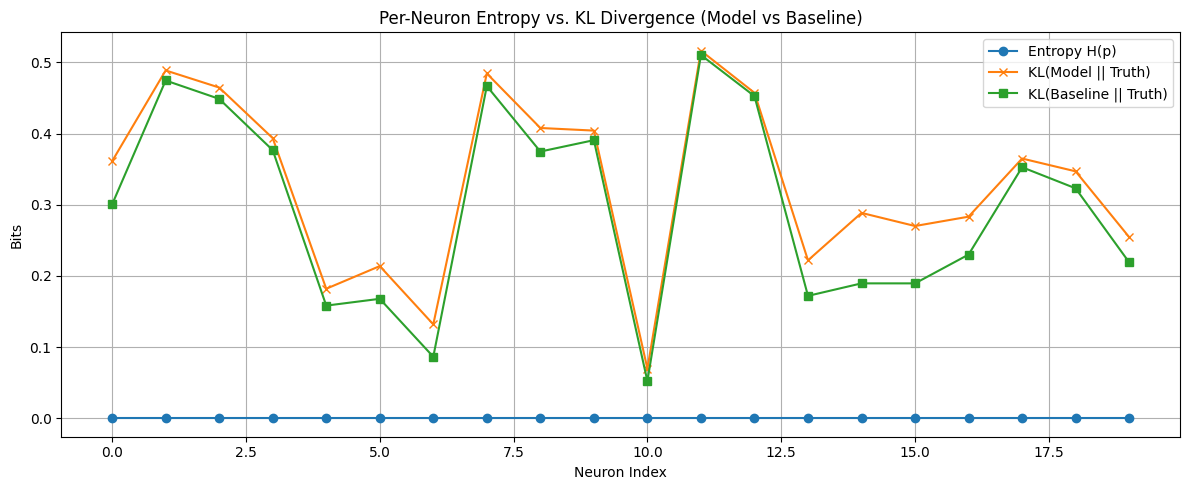

In [9]:
# Re-import after kernel reset
import numpy as np
import matplotlib.pyplot as plt

def estimate_entropy_and_kl(p_true, p_model, baseline_probs):
    eps = 1e-6
    p_true = np.clip(p_true, eps, 1 - eps)
    p_model = np.clip(p_model, eps, 1 - eps)
    baseline_probs = np.clip(baseline_probs, eps, 1 - eps)

    entropy = - (p_true * np.log(p_true) + (1 - p_true) * np.log(1 - p_true)).mean(axis=0)
    ce_model = - (p_true * np.log(p_model) + (1 - p_true) * np.log(1 - p_model)).mean(axis=0)
    ce_baseline = - (p_true * np.log(baseline_probs) + (1 - p_true) * np.log(1 - baseline_probs)).mean(axis=0)

    kl_model = ce_model - entropy
    kl_baseline = ce_baseline - entropy

    return entropy, kl_model, kl_baseline

# Simulated realistic example
np.random.seed(42)
N = 1000
neurons = 20
p_baseline = np.random.uniform(0.01, 0.2, size=(neurons,))
p_true = np.random.binomial(1, p_baseline, size=(N, neurons))
p_model = np.clip(p_baseline + np.random.normal(0, 0.05, size=(N, neurons)), 1e-4, 1-1e-4)

# Compute metrics
entropy, kl_model, kl_baseline = estimate_entropy_and_kl(p_true, p_model, p_baseline)

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(entropy, label='Entropy H(p)', marker='o')
plt.plot(kl_model, label='KL(Model || Truth)', marker='x')
plt.plot(kl_baseline, label='KL(Baseline || Truth)', marker='s')
plt.xlabel("Neuron Index")
plt.ylabel("Bits")
plt.title("Per-Neuron Entropy vs. KL Divergence (Model vs Baseline)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


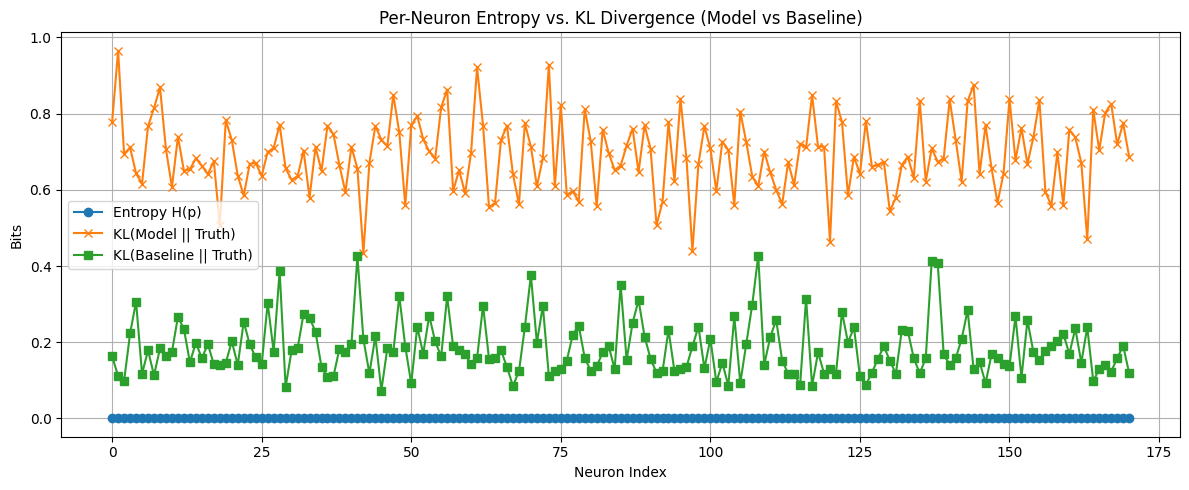

Mean Entropy: 0.0000
Mean KL(model || truth): 0.6908
Mean KL(baseline || truth): 0.1834


In [10]:
def evaluate_entropy_and_kl_from_fold(
    merged_folds, 
    fold, 
    model_path="/home/maria/MouseViT/trained_models/zig_binary_event_fold.pth"
):
    """
    Evaluates per-neuron entropy and KL divergence (model vs truth, baseline vs truth)
    and visualizes the results.

    Args:
        merged_folds (list): List of folds from your cross-validation split.
        fold (int): Fold number to evaluate.
        model_path (str): Path to trained PyTorch model.

    Returns:
        entropy (np.ndarray): Entropy per neuron
        kl_model (np.ndarray): KL(model || truth) per neuron
        kl_baseline (np.ndarray): KL(baseline || truth) per neuron
    """
    import torch
    import torch.nn.functional as F

    # Load model and data
    checkpoint = torch.load(model_path, map_location="cpu")
    Xn_train, Xe_train, Xn_test, Xe_test, _, _ = merged_folds[fold]

    yDim = Xn_train.shape[1]
    xDim = Xe_train.shape[1]
    model = ZIG(neuronDim=yDim, xDim=xDim)
    model.load_state_dict(checkpoint)
    model.eval()

    # Compute required arrays
    Xe_test_tensor = torch.tensor(Xe_test, dtype=torch.float32)
    with torch.no_grad():
        p_model = model(Xe_test_tensor).cpu().numpy()
    p_model = np.clip(p_model, 1e-6, 1 - 1e-6)

    p_true = (Xn_test > 0).astype(np.float32)
    p_baseline = (Xn_train > 0).mean(axis=0)
    p_baseline_full = np.tile(np.clip(p_baseline, 1e-6, 1 - 1e-6), (Xn_test.shape[0], 1))

    # Estimate entropy and KL
    entropy, kl_model, kl_baseline = estimate_entropy_and_kl(p_true, p_model, p_baseline_full)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(entropy, label='Entropy H(p)', marker='o')
    plt.plot(kl_model, label='KL(Model || Truth)', marker='x')
    plt.plot(kl_baseline, label='KL(Baseline || Truth)', marker='s')
    plt.xlabel("Neuron Index")
    plt.ylabel("Bits")
    plt.title("Per-Neuron Entropy vs. KL Divergence (Model vs Baseline)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Mean Entropy: {entropy.mean():.4f}")
    print(f"Mean KL(model || truth): {kl_model.mean():.4f}")
    print(f"Mean KL(baseline || truth): {kl_baseline.mean():.4f}")

    return entropy, kl_model, kl_baseline

entropy, kl_model, kl_baseline = evaluate_entropy_and_kl_from_fold(
    merged_folds, 
    fold=0, 
    model_path="/home/maria/MouseViT/trained_models/zig_binary_event_fold.pth"
)

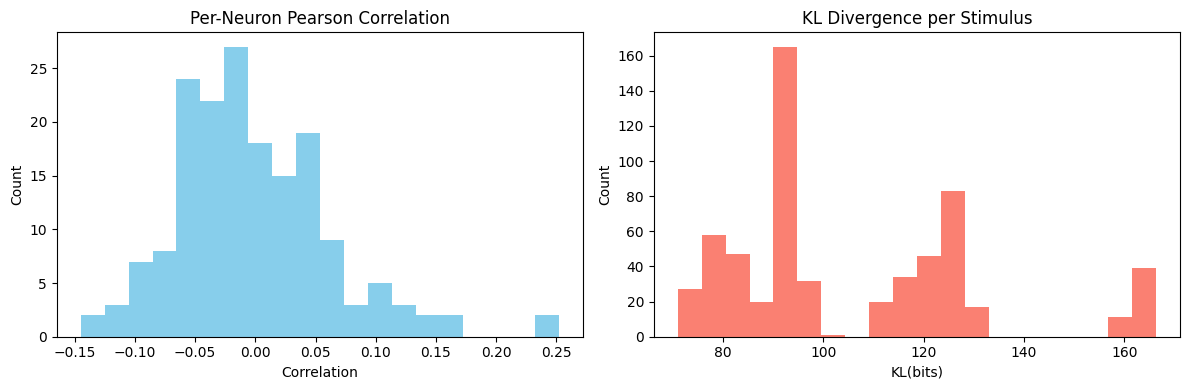

In [38]:
def compute_neuron_correlation_and_stimuluswise_kl(
    merged_folds, 
    fold, 
    model_path="/home/maria/MouseViT/trained_models/zig_binary_event_fold.pth"
):
    """
    Computes:
    1. Per-neuron Pearson correlation between predicted and true spikes.
    2. Per-stimulus KL divergence between predicted and true spike patterns.

    Args:
        merged_folds (list): List of data folds.
        fold (int): Which fold to evaluate.
        model_path (str): Path to trained ZIG model.

    Returns:
        corr_per_neuron (np.ndarray): shape (num_neurons,)
        kl_per_stimulus (np.ndarray): shape (num_samples,)
    """
    import torch
    from scipy.stats import pearsonr
    import numpy as np
    import matplotlib.pyplot as plt

    from src.zig_model import ZIG  # Adjust this import if needed

    # Load model and data
    checkpoint = torch.load(model_path, map_location="cpu")
    Xn_train, Xe_train, Xn_test, Xe_test, _, _ = merged_folds[fold]

    yDim = Xn_train.shape[1]
    xDim = Xe_train.shape[1]
    model = ZIG(neuronDim=yDim, xDim=xDim)
    model.load_state_dict(checkpoint)
    model.eval()

    # Predict probabilities
    Xe_test_tensor = torch.tensor(Xe_test, dtype=torch.float32)
    with torch.no_grad():
        p_model = model(Xe_test_tensor).cpu().numpy()

    # Ground truth binary labels
    p_true = (Xn_test > 0).astype(np.float32)

    # 1. Per-neuron Pearson correlation
    corr_per_neuron = np.array([
        pearsonr(p_true[:, j], p_model[:, j])[0] if np.std(p_true[:, j]) > 0 else np.nan
        for j in range(yDim)
    ])

    # 2. Per-stimulus KL divergence
    eps = 1e-6
    p_true = np.clip(p_true, eps, 1 - eps)
    p_model = np.clip(p_model, eps, 1 - eps)

    kl_per_stimulus = (
        (1 - p_true) * np.log((1 - p_true) / (1 - p_model)) +
         p_true       * np.log(  p_true     /   p_model)
    ).sum(axis=1)

    # Optional plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(corr_per_neuron[~np.isnan(corr_per_neuron)], bins=20, color='skyblue')
    axes[0].set_title("Per-Neuron Pearson Correlation")
    axes[0].set_xlabel("Correlation")
    axes[0].set_ylabel("Count")

    axes[1].hist(kl_per_stimulus, bins=20, color='salmon')
    axes[1].set_title("KL Divergence per Stimulus")
    axes[1].set_xlabel("KL(bits)")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    return corr_per_neuron, kl_per_stimulus, p_model, p_true
corrs, kls, p_model, p_true = compute_neuron_correlation_and_stimuluswise_kl(merged_folds, fold=0)

In [13]:
print(corrs.shape)

(171,)


In [16]:
p_model.shape
p_true.shape

(600, 171)

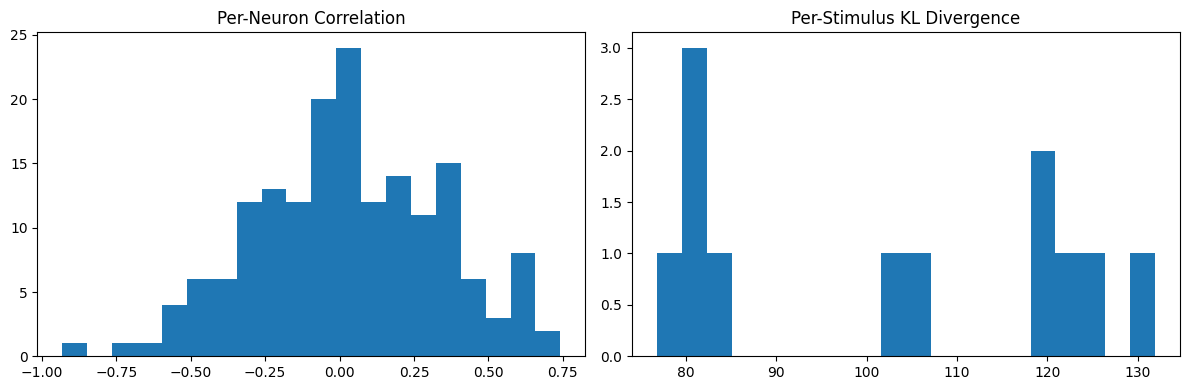

In [46]:
import numpy as np
import torch
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from collections import defaultdict
from src.zig_model import ZIG  # <- update if needed

def compute_neuron_correlation_and_stimuluswise_kl(merged_folds, fold, model_path="/home/maria/MouseViT/trained_models/zig_binary_event_fold.pth"):
    Xn_train, Xe_train, Xn_test, Xe_test, _, frames_test = merged_folds[fold]

    model = ZIG(neuronDim=Xn_train.shape[1], xDim=Xe_train.shape[1])
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    with torch.no_grad():
        p_model = model(torch.tensor(Xe_test, dtype=torch.float32)).cpu().numpy()

    p_true = (Xn_test > 0).astype(np.float32)
    frame_to_idx = defaultdict(list)
    for idx, f in enumerate(frames_test): frame_to_idx[f].append(idx)

    frames = sorted(frame_to_idx.keys())
    p_model_avg = np.array([p_model[frame_to_idx[f]][0] for f in frames])
    p_true_avg = np.array([p_true[frame_to_idx[f]].mean(0) for f in frames])

    # Correlation per neuron
    corr = np.array([
        pearsonr(p_true_avg[:, i], p_model_avg[:, i])[0]
        if np.std(p_true_avg[:, i]) > 0 else np.nan
        for i in range(p_true_avg.shape[1])
    ])

    # KL per stimulus
    eps = 1e-6
    pt = np.clip(p_true_avg, eps, 1 - eps)
    qt = np.clip(p_model_avg, eps, 1 - eps)
    kl = ((1 - pt) * np.log((1 - pt)/(1 - qt)) + pt * np.log(pt/qt)).sum(1)

    # Optional plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(corr[~np.isnan(corr)], bins=20)
    plt.title("Per-Neuron Correlation")
    plt.subplot(1, 2, 2)
    plt.hist(kl, bins=20)
    plt.title("Per-Stimulus KL Divergence")
    plt.tight_layout()
    plt.show()

    return corr, kl, p_model_avg, p_true_avg, p_model
corr, kl, p_model_avg, p_true_avg, p_model=compute_neuron_correlation_and_stimuluswise_kl(merged_folds, fold=0)


In [45]:
p_model

array([[0.43789008, 0.38016167, 0.38959593, ..., 0.32484832, 0.5178255 ,
        0.4126535 ],
       [0.32295498, 0.42685044, 0.4065331 , ..., 0.40005141, 0.383805  ,
        0.3955257 ],
       [0.38184085, 0.4100435 , 0.43265218, ..., 0.38890392, 0.42260638,
        0.40003127],
       ...,
       [0.3786856 , 0.3259761 , 0.37987694, ..., 0.320782  , 0.2826649 ,
        0.4019513 ],
       [0.5187757 , 0.5021263 , 0.49128172, ..., 0.4954612 , 0.56227034,
        0.516305  ],
       [0.39921984, 0.48140216, 0.4181697 , ..., 0.40931484, 0.37562105,
        0.49135736]], dtype=float32)

[0.51670736 0.62302154 0.6470277  0.26264438 0.46117717 0.18957618
 0.47426093 0.269843   0.22352359 0.13423504 0.23906673 0.5527012
 0.6482767  0.5907874  0.83389544 0.61616623 0.532129   0.28910172
 0.6507819  0.5071862  0.61088395 0.26350072 0.70193    0.5016495
 0.1711734  0.75925684 0.6249847  0.77821    0.33324018 0.77733797
 0.67865175 0.31612507 0.4061139  0.96530414 0.60314304 0.34570262
 0.7556113  0.51133984 0.68538564 0.7579915  0.34899777 0.6427173
 0.526966   0.27467448 0.5146684  0.24749175 0.5430521  0.65538704
 0.61957216 0.32789832 0.17369649 0.49651235 0.6525854  0.5017747
 0.6109213  0.4736012  0.6942119  0.48162478 0.20893662 0.5035116
 0.3803657  0.42422912 0.53079414 0.34759304 0.29673713 0.6940064
 0.82395583 0.41308352 0.6953579  0.19529963 0.55396456 0.5112661
 0.71427935 0.718253   0.5639203  0.7025986  0.41390738 0.5787765
 0.26986253 0.7557138  0.6690574  0.37548107 0.47138664 0.41605133
 0.7508204  0.51594037 0.65692407 0.6276763  0.5227831  0.36022794
 0.

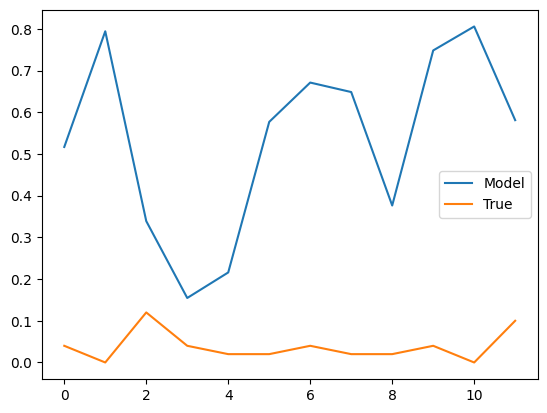

In [47]:
print(p_model_avg[0])
print(p_true_avg[0])

plt.plot(p_model_avg[:,0], label='Model')
plt.plot(p_true_avg[:,0], label='True')
plt.legend()

In [48]:
print(kl)

[119.54555  131.9205   125.01084   81.461426  82.056076  79.54623
 122.45776  102.60928  105.78633  119.61331   84.39845   76.77607 ]


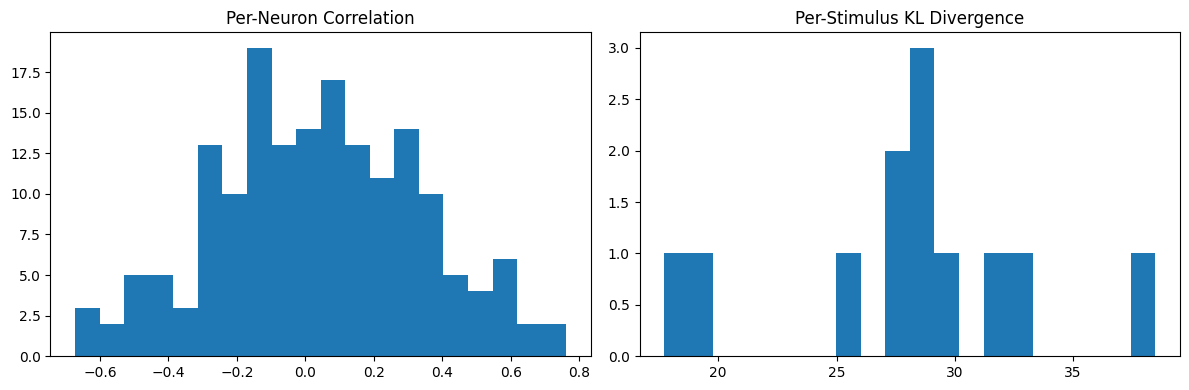

In [50]:
def compute_neuron_correlation_and_stimuluswise_kl(
    merged_folds,
    fold,
    model_path="/home/maria/MouseViT/trained_models/zig_binary_event_fold.pth"
):
    """
    Evaluates the model by:
    1. Normalizing empirical spike rates across stimuli (per neuron),
    2. Computing Pearson correlation between normalized true rates and model predictions,
    3. Computing KL divergence per stimulus between normalized rates and predicted probabilities.
    """
    import torch
    from src.zig_model import ZIG  # <-- adjust if needed

    Xn_train, Xe_train, Xn_test, Xe_test, _, frames_test = merged_folds[fold]

    model = ZIG(neuronDim=Xn_train.shape[1], xDim=Xe_train.shape[1])
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    with torch.no_grad():
        p_model = model(torch.tensor(Xe_test, dtype=torch.float32)).cpu().numpy()

    p_true = (Xn_test > 0).astype(np.float32)

    from collections import defaultdict
    frame_to_idx = defaultdict(list)
    for idx, f in enumerate(frames_test):
        frame_to_idx[f].append(idx)

    frames = sorted(frame_to_idx.keys())
    p_model_avg = np.array([p_model[frame_to_idx[f]][0] for f in frames])
    p_true_avg_raw = np.array([p_true[frame_to_idx[f]].mean(0) for f in frames])

    # Normalize p_true_avg per neuron to emphasize modulation (rescale to [0.25, 0.75])
    min_vals = p_true_avg_raw.min(axis=0)
    max_vals = p_true_avg_raw.max(axis=0)
    norm = (p_true_avg_raw - min_vals) / (max_vals - min_vals + 1e-6)
    p_true_avg = 0.25 + 0.5 * norm

    # Correlation per neuron
    corr = np.array([
        pearsonr(p_true_avg[:, i], p_model_avg[:, i])[0]
        if np.std(p_true_avg[:, i]) > 0 else np.nan
        for i in range(p_true_avg.shape[1])
    ])

    # KL per stimulus
    eps = 1e-6
    pt = np.clip(p_true_avg, eps, 1 - eps)
    qt = np.clip(p_model_avg, eps, 1 - eps)
    kl = ((1 - pt) * np.log((1 - pt)/(1 - qt)) + pt * np.log(pt/qt)).sum(1)

    # Optional plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(corr[~np.isnan(corr)], bins=20)
    plt.title("Per-Neuron Correlation")
    plt.subplot(1, 2, 2)
    plt.hist(kl, bins=20)
    plt.title("Per-Stimulus KL Divergence")
    plt.tight_layout()
    plt.show()

    return corr, kl, p_model_avg, p_true_avg, p_model

corr, kl, p_model_avg, p_true_avg, p_model=compute_neuron_correlation_and_stimuluswise_kl(merged_folds, fold=0)

[0.28704453 0.69676757 0.7124729  0.41552043 0.5924584  0.38682792
 0.52129465 0.19797954 0.29618746 0.40614086 0.428665   0.45650315
 0.752055   0.70148635 0.5365846  0.38758752 0.5285625  0.45817006
 0.69564706 0.21538205 0.837853   0.4433247  0.46477532 0.7346404
 0.16480908 0.7371512  0.6071464  0.74396336 0.54302704 0.644184
 0.56199384 0.25091767 0.64938945 0.9476155  0.55692846 0.41497326
 0.7700222  0.478309   0.6933505  0.6589229  0.2367996  0.62144464
 0.34455785 0.71011907 0.64019364 0.4197461  0.46665812 0.74698377
 0.4502569  0.3160999  0.36487716 0.47473833 0.61277825 0.721759
 0.590692   0.2536457  0.4824396  0.28628957 0.5493216  0.3349831
 0.46428034 0.50541663 0.50260514 0.5050543  0.44132498 0.53012776
 0.771071   0.46152738 0.6705308  0.29394397 0.44731322 0.5213758
 0.66813135 0.776578   0.34791327 0.71205866 0.6376114  0.54119277
 0.4067707  0.7030576  0.35075054 0.44540742 0.34676906 0.51850116
 0.81793916 0.29267043 0.610144   0.53166336 0.2839109  0.63321793
 0

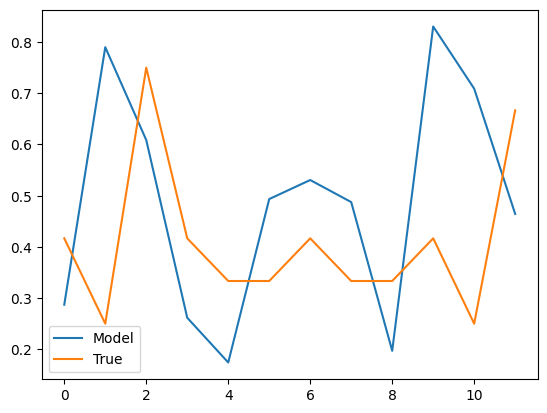

In [51]:
print(p_model_avg[0])
print(p_true_avg[0])

plt.plot(p_model_avg[:,0], label='Model')
plt.plot(p_true_avg[:,0], label='True')
plt.legend()